# Kostadinov Samuel, Deep Learning project A.Y. 2021/2022

# Introduction


Domain adaptation is an important task in Machine Learning, and it's still vastly studied. 
The problem can be formalized as the task of transferring some already acquired knowledge to a new scenario. In particular, considering Deep Learning domain adaptation, the typical setting includes a pretrained deep learning model, that is already trained on a domain and the goal is to transfer the acquired knowledge to another domain. There are also some other cases in which a single dataset can present multiple domains. These datasets are usually thought in the first place to test domain adaptation methods and include the same classes captured in multiple domains. Examples of this type of dataset can be Adaptiope [[1]](#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1) or Office-31 [[2]](#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1).


In this project is shown an implementation of "GCAN: Graph Convolutional Adversarial Network for unsupervised domain adaptation" [[3]](#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1) (GCAN), proposed in CVPR 2019. This method exploits graph neural networks to achieve the goal of domain adaptation without the use of the target set labels, which classifies this method between the methods for Unsupervised Domain Adaptation (UDA).


# Environment setup


This project needs the library `pytorch_geometric`, and since Google Colab does not provide it by default, there is the need to install it. Installing this library, though, will cause some compatibility issues with `pytorch`, and to resolve them `pytorch` gets uninstalled and reinstalled in a newer version. The same is true for `torchtext`, `torchaudio` and `torchvision`, the only difference is that only `torchvision` get reinstalled since there is no need to use `torchtext` and `torchaudio`.

The installation commands are copy-pasted from the guide on [PyTorch](https://pytorch.org/get-started/locally/)'s and [pytorch_geometric](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)'s sites.



In [ ]:
!pip uninstall -q torchtext -y 
!pip uninstall -q torchaudio -y 
!pip uninstall -q torchvision -y
!pip uninstall -q torch -y 
!pip install -q torch torchvision --extra-index-url https://download.pytorch.org/whl/cu116
!pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html 

Due to some CUDA Out Of Memory issues, there was the need to modify the max split size, so that the internal fragmentation is reduced. The value of 128Mb was found experimentally.

In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF = max_split_size_mb:128

# Getting the data


The dataset used in this work is Adaptiope [[1]](#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1) and it's contained in a Drive folder on the account that was used for this project. The zip version of the dataset is expected to be in Google Drive, inside a folder named Adaptiope.

The following cell is therefore necessary to access the dataset, since it can grant the access to one's Drive Account.

Notice that the presence of the folder Adaptiope in Drive with the zipped dataset in it is the only prerequisite for this notebook to work correctly. In case it's needed, the dataset can be found [here](https://drive.google.com/file/d/1FmdsvetC0oVyrFJ9ER7fcN-cXPOWx2gq/view).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

After mounting drive, the zip file containing the dataset can be accessed, so 
the following command is needed to unzip the folder. 

In [ ]:
!unzip -q '/content/gdrive/MyDrive/Adaptiope/Adaptiope.zip'

# Preliminary operations

The following cell, as first operation of the actual work, imports everything that is needed for the code to work.

In [ ]:
# All imports will be here to give a complete overview of all the necessary modules
import os
import time
import subprocess
import random

from tqdm import tqdm
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.nn.functional import relu, softmax
import torch.cuda as cuda
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
from torchvision import transforms

from torch_geometric import nn as geometric_nn
from torch_geometric.data import Data as geometric_data
from torch_geometric.utils import dense_to_sparse

For reproducibility reasons, a pytorch seed and a random seed are set manually. It's important to report that changing the seed may vary the results. Even though the project was tested with multiple seeds, the parameters were tuned to work best with these seeds.

In [ ]:
random.seed(42) # randomly chosen between 1 and 100 with https://g.co/kgs/z4eCyj
torch.manual_seed(5207729410797275978)  # torch seed of the first experiment performed

The following cell declares some variables that will be used throughout the 
execution.

In [ ]:
device = 'cuda:0' if cuda.is_available() else 'cpu'
train_epochs = 5
uda_train_epochs = 15
learning_rate = 1e-3
uda_learning_rate = 5e-4
batch_size = 64
train_perc = 0.8
root_path = '/content/Adaptiope/'

# Operations on the data

The following two cells prepare the data to be used. This project does not use the entirety of the Adaptiope dataset, but just 20 classes from 2 of the 3 domains of the dataset. 

The following cell first of all deletes the `synthetic` path inside the dataset folder, since it's the domain that will not be used. Then creates the variables for the path of the two domains that will be used.

In [ ]:
class_list = ['backpack', 'bookcase', 'car jack', 'comb', 'crown', 'file cabinet', 'flat iron', 'game controller', 'glasses', 'helicopter', 
              'ice skates', 'letter tray', 'monitor', 'mug', 'network switch', 'over-ear headphones', 'pen', 'purse', 'stand mixer', 'stroller']

synthetic_path = os.path.join(root_path, 'synthetic')
subprocess.call(f'rm -r {synthetic_path}', shell=True)

real_world_path = os.path.join(root_path, 'real_life')
products_path = os.path.join(root_path, 'product_images')

The following cell, then, deletes from the folders of the two used domains the folder corresponding to classes that are not used.

In [ ]:
for current_class in os.listdir(real_world_path):

    if current_class not in class_list:
        real_path = os.path.join(root_path,'real_life','"' + current_class + '"')
        prod_path = os.path.join(root_path,'product_images','"' + current_class + '"')

        subprocess.call(f'rm -r {real_path}', shell=True)
        subprocess.call(f'rm -r {prod_path}', shell=True)

The cell below defines a function which is used both by the Source only training and Unsupervised Domain Adaptation techniques. The transforms used here are all implemented by pytorch. In particular, the whole project relies on the `CenterCrop` and the `ToTensor` since these two are fundamental operations. The first one makes sure that the image matches the input size of the backbone model, which is in the case of this project a ResNet50 [[4]](#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1), while the second one makes sure the output of the transform is a `tensor` and not an image.

In [ ]:
def get_transform():

    transform = list()
    transform.append(transforms.Resize((256, 256)))
    transform.append(transforms.CenterCrop((224, 224)))
    transform.append(transforms.RandomHorizontalFlip(0.5))
    transform.append(transforms.RandomVerticalFlip(0.5))
    transform.append(transforms.GaussianBlur((3, 3)))
    transform.append(transforms.ToTensor())

    return transforms.Compose(transform)

# Source only 

In this part some functions are implemented to train and evaluate the backbone model, using only the source data as training data and testing on the target domain.

## Evaluation functions

In this section, two function are presented to evaluate a model. The one in the following cell takes the model, the DataLoader, the loss function and the device. The loss function and the device have a default value. For the loss function, the default is `nn.CrossEntropyLoss()`, implemented by pytorch, while the device is by default `cuda:0`.

In [ ]:
def evaluate_net(model, data_loader, loss_function=nn.CrossEntropyLoss(), device='cuda:0'):

    start = time.time()
    samples = 0
    cumulative_acc = 0
    cumulative_loss = 0

    model.eval()

    # Since there is no backward pass the gradient is not needed
    with torch.no_grad():
        
        for batch_index, (input, target) in enumerate(tqdm(data_loader, desc='Progress')):

            input = input.to(device)
            target = target.to(device)

            output = model.forward(input)
            loss = loss_function(output, target)

            samples += input.shape[0]
            cumulative_loss += loss.item()
            _, predicted = output.max(1)

            cumulative_acc += predicted.eq(target).sum().item()
    
    end = time.time()

    return (cumulative_acc / samples) * 100, cumulative_loss / samples, end - start

The following cell has the purpose to invoke the function that evaluates the network and print the results. 

In [ ]:
def evaluate_baseline_network(model, data_loader, device, loss_function=nn.CrossEntropyLoss()):

    test_acc, test_loss, elapsed_time = evaluate_net(model, data_loader, device, loss_function)
    print(f'Accuracy of the model without any domain adaptation: {round(test_acc, 5)}%')
    # print(f'Loss of the model without any domain adaptation: {test_loss}')
    print(f'Testing done in {elapsed_time} seconds')

## Train functions

The following two cells, similarly to the [evaluation ones](#scrollTo=Kg2avoOTbIYF&line=1&uniqifier=1) are the ones that are called when training the model.

The first cell is responsible for a single epoch of training. In particular it gets as input the model, the data loader, the loss function and the device. As in the evaluation function, the loss function is by default pytorch's `CrossEntropyLoss` and the default device is `cuda:0`.

Regarding the `set_to_none` attribute, it was set to have generally a lower memory footprint, as [the documentation](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) states. This advantage is obtained because the grads are set to `None`. This comes with some drawbacks, involving different behaviours with manual operations, backward pass and optimizer behaviour. These drawbacks are, fortunately, not an issue in this case, since there are no manual operations on the grads,the backward pass and the optimizer's step are done before setting the gradient to `None`.

In [ ]:
def train_epoch(model, data_loader, optimizer, loss_function=nn.CrossEntropyLoss(), device='cuda:0'):

    samples = 0
    cumulative_acc = 0
    cumulative_loss = 0

    model.train()

    for batch_idx, (input, target) in enumerate(tqdm(data_loader, desc='Progress')):

        input = input.to(device)
        target = target.to(device)

        output = model.forward(input)

        loss = loss_function(output, target)
        loss.backward()

        optimizer.step()
        # set_to_none is set to True to reduce memory footprint. See the text cell above for more details
        optimizer.zero_grad(set_to_none=True)

        samples += input.shape[0]
        cumulative_loss += loss.item()
        _, predicted = output.max(1)

        cumulative_acc += predicted.eq(target).sum().item()
    
    return (cumulative_acc / samples) * 100, cumulative_loss / samples 

The following cell has the goal of performing the whole process of the Source 
only training of the model, while relying on `train_epoch` for the single epoch training. This function first defines a log directory and creates a `SummaryWriter` object to log the progress which will be later visualized by the tensorboard. Then for each epoch the `train_epoch` and `evaluate_net` functions are called on the training set and the corresponding scalars for accuracy and loss are logged into the log directory. At the end of all the epochs, the network is evaluated on the target test set.
The `loss_function`, `source` and `device` field have a default value set to `CrossEntropyLoss`, `real_world` and `cuda:0` respectively.

In [ ]:
def source_only_training(source, counter, train_epochs, model, train_dataloader, 
                          optimizer, loss_function, device, test_dataloader_source,
                          target_dataloader):

    # Performing fine tuning on source domain and testing on target domain
    if source == 'real_world':
        print('Training on real world and testing on products')
        dir = 'exp_real_to_products'
    else:
        print('Training on products and testing on real world')
        dir = 'exp_products_to_real'
    
    
    path = os.path.join('runs', dir)
    writer = SummaryWriter(log_dir=path)

    start = time.time()
    for epoch in range(train_epochs):
        
        print(f'Epoch {epoch + 1} / {train_epochs}')
        acc, loss = train_epoch(model, train_dataloader, optimizer, loss_function, device)
        test_acc, test_loss, _ = evaluate_net(model, test_dataloader_source, loss_function, device)
        print(f'Train accuracy of the model after {epoch + 1} epochs: {round(acc, 5)}%')
        print(f'Test accuracy of the model after {epoch + 1} epochs: {round(test_acc, 5)}%')
        

        writer.add_scalar('Loss/train_loss', loss, epoch + 1)
        writer.add_scalar('Accuracy/train_accuracy', acc, epoch + 1)
        writer.add_scalar('Loss/test_loss', test_loss, epoch + 1)
        writer.add_scalar('Accuracy/test_accuracy', test_acc, epoch + 1)
    
    writer.flush()  # makes sure all pending events are written to disk
    writer.close()
    
    end = time.time()
    print(f'The training finished in {end - start} seconds')
    print('-' * 70)

    test_acc, test_loss, elapsed_time = evaluate_net(model, target_dataloader, loss_function, device)
    print(f'Transfer accuracy: {round(test_acc, 5)}%')
    print(f'Transfer loss: {round(test_loss, 5)}')
    print(f'Testing done in {elapsed_time} seconds')

## Other operations for Source Only Training

The following cell returns an optimizer for the model used in the Source Only 
task. In this case the function supposes that the model is a ResNet pretrained on ImageNet [[5]](#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1) with the last layer replaced by another fully connected layer to match the number of classes. In this case, the model needs to train from scratch the last layer, while only fine tune the other layers. This functions divides the parameters of the last layer from the others, assigning to the layer to train from scratch the `learning_rate` given as input, while the same learning rate divided by ten for the other layers. 

In [ ]:
def get_sup_optimizer(model, lr):

    from_scratch = list()
    others = list()

    for name, param in model.named_parameters():

        if name.startswith('fc'):
            from_scratch.append(param)
        else:
            others.append(param)

    return Adam([        
        {'params': others},    
        {'params': from_scratch, 'lr': learning_rate}
    ], lr=lr/10)

The two cells below are related to the data of the Source Only training. 

The first one creates the dataset starting from a `path`, given a `transform` and a `train_split` (which by default is set to 0.8).
The dataset creation relies on the `ImageFolder` class provided by pytorch, specifically designed for vision datasets. Fortunately, the tree structure of Adaptiope follows the one required by `ImageFolder`. 
After the creation of the dataset, this function also splits it randomly into train and test set using pytorch's function `random_split`.

In [ ]:
def create_supervised_dataset(path, transform, train_split=0.8):
    
    dataset = ImageFolder(path, transform=transform)
    number_of_train = int(len(dataset) * train_split)
    number_of_test = len(dataset) - number_of_train
    return random_split(dataset, [number_of_train, number_of_test])

The following cell has a very simple goal, which is to return the `DataLoader` corresponding to the data passed as first argument of the function. As default choice it was decided to drop the last batch and use `pin_memory` to make the loading faster.

In [ ]:
def get_dataloader(data, shuffle=True, batch_size=64):

    return DataLoader(data, batch_size=batch_size, shuffle=shuffle, pin_memory=True, drop_last=True)

# Unsupervised Domain Adaptation (UDA)

Unsupervised Domain Adaptation, for short UDA, is a form of domain adaptation. The main characteristic of the UDA is that the labels of the target domain are not given, so it's not possible to use them, while the source domain has samples and labels that can be called `s` and `ys` respectively. The other domain, which can be called `t` does not have any label. The goal is to find a way in which a model can trasnfer knowledge from the source domain to the target domain.

There is a high variety of methods to achieve this goal, and the one implemented here is one of the possible approaches to this problems. According to [[6]]((#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1)), the possible approaches can be divided into:

1.   **Domain Invariant Feature Learning**: The main idea of these methods is to make a classifier learn to perform well on a source domain using domain independent feature to make it perform well also in the target domain.

2.   **Domain Mapping**: As the name says, this approach aims at learning a mapping from the source domain to the target domain, usually using pixel-level adversarial methods.

3.   **Normalization Statistics**: According to the authors these methods exploit the statistics contained in the batch normalization layers contained in most networks to adapt from the source to the target domain.

4.   **Ensemble Methods**: These methods are based on the fact that ensembling different models would result in the models making different mistakes and exploiting this aspect can lead to a performance gain.

5.   **Target Discriminative Methods**: These methods are based on the assumption that data points are distributed in separate clusters, and that data points of the same cluster have the same label. In this case, the region boundaries should be in low-density regions. Different techniques can be 
exploited to find these boundaries. 

6.   **Combinations**: As the name suggests, the methods of this category are based on combinations of the above categories. 

The approach used in this project is called GCAN: Graph Convolutional Adversarial Network for Unsupervised Domain
Adaptation [[3]](#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1). This approach is, according to the authors of the paper itself, part of the first category. In fact they explicitly state that the model they build can learn domain-invariant and semantic features.


## Paper details

### Main idea

The main idea behind GCAN is to train a model jointly on 3 different aspects that are considered very important, according to the opinion of the paper's authors, in domain adaptation. These aspects are: data structure, domain label and class label. These 3 mechanisms are designed to align domain distribution robustly and use data from both source and target domain.

### Model

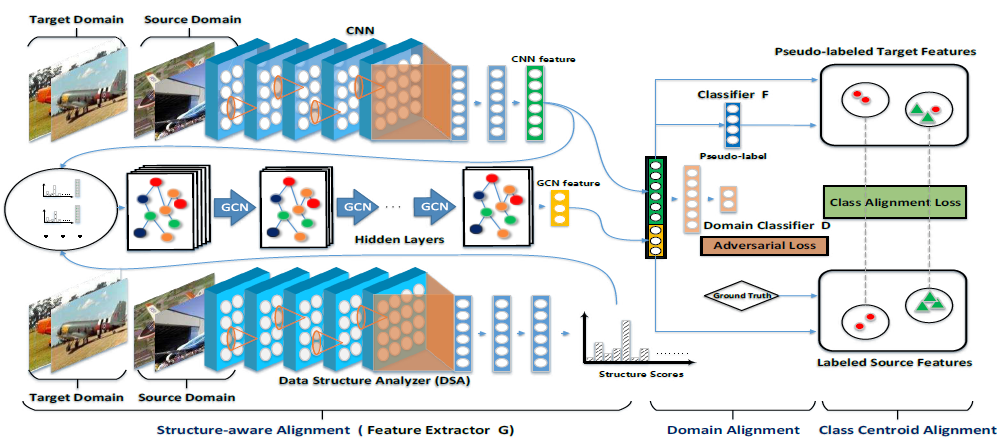

To achieve the goal of domain adaptation, the authors of the paper designed the model shown in the picture above. 
Given an input `x`, the model performs some steps in the forward pass:

1.   A deep CNN architecture is used as feature extractor on `x`
2.   Another deep CNN architecture is used (with the final layer included) to generate structes scores. This module is called Data Structure Analyzer (DSA)
3.   The CNN features and the structe scores are used to generate a graph fed to a Graph Convolutional Network (GCN) that produces the GCN features
4.   The features of the first CNN and the GCN features are then concatenated
5.   The concatenated features are fed to a classifier and a domain classifier.





### Loss function

After defining the model, the authors had to design a proper loss function. The loss function they came up with is composed of 4 different components:


1.   **A classification loss**: This is the most important component of the loss. Since the problem is Unsupervised Domain Adaptation, the loss is computed only on the labeled source domain samples. The classification loss is a standard cross entropy loss.
2.   **A domain classification loss**: The model predicts the domain of the current input, and the prediction is compared with the groundtruth with a standard adversarial loss.
3.   **A structure-aware alignment**: To constrain even more the scores and guide the DSA, the authors implement a triplet loss. First of all they sample three inputs making sure that they're from the source domain, two of them being of the same class and one being part of a different class. They then model the similarity of the samples. Supposing the similarity of the two samples of the same class is $scs$ and the similarity of the samples of the different class is $dcs$ the authors compute $l = scs - dcs + T$, where T is a predefined threshold. The result is $L=max(l, 0)$
4.   **A class centroid alignment**: This loss has the function to make sure the different class remain discriminable. In particular, the authors use the source class label information and the pseudo labels predicted for the target domain to make sure samples of the same class are mapped near each other and far from the samples of other classes. In particular, the authors compute the centroid of the classes, and minimize the sum of the distances of all the centroids. Supposing that $C_S^K$ is the centroid of class $K$ from the source domain and that $C_T^K$ is the same for the target domain, the function to minimize is $\sum_{k=1}^{K} \phi(C_S^K, C_T^K)$, where $\phi$ is a distance measure.

The final loss is then a weighted sum of these 4 components.

### Hyper-parameteres

The hyper-parameters of this model are not only the parameters regarding the number of layers, the number of features and the number of epochs. Since the loss function is in the form of a weighted sum, also those weights are hyper-parameters to tune.


### Implementation details and differences with original paper


In the original paper the GCAN model uses AlexNet [[7]](#scrollTo=JcndGS9kQmNr&line=9&uniqifier=1) as CNN and DSA modules, GCN as graph convolutional model and two multi-layer perceptrons as classifiers, both for class and domain classification. In this project, instead of using AlexNet, a ResNet was used. The main reason behind this difference lays in the number of parameters of the two networks, in fact the ResNet50, despite being deeper than AlexNet, has less parameters, while also achieving better performances. 

Another key difference regards some of the hyper-parameters. In the original paper, in fact, there are some varying parameters. In this project, thought, instead of varying the parameters, a grid search approach was applied to find the best parameters for this dataset. The results' table is reported [here](#scrollTo=ofW_iZI9AiAb&line=1&uniqifier=1).

The loss functions also has something to notice, in fact the authors of the paper do not explicitly say what type of similarity measure they used in the triplet loss. Since they used the squared euclidean distance for the class alignment, in this project the similarity function used in the triplet loss is the squared euclidean distance. 

As last point to emphasize, in the original paper the `batch_size` used in the experiments was 128, while in this project is set to 64 due to CUDA Out Of Memory issues.

## GCAN Dataset

The following cell implements a custom dataset for the UDA training process. Since it uses both source and target paths, the dataset has to keep track of the domain of each sample, but since the domain is an information to be returned in the `__getitem__` method this comes almost automatically.

In the `__init__` method the dataset stores the paths of the images from the source and target domain. After loading every path, from the dataset samples randomly the test set from the target domain, while all the other samples are used in the train set.

The `__getitem__` function just returns the image, the label and the domain corresponding to the sample in the given position. 

The `__len__` method return the numebr of files in the dataset.

In [ ]:
class GCANDataset(Dataset):

    def __init__(self, source_path, target_path, class_list, train_portion=0.8, transform=None):

        self.transform = transform
        self.file_counter = 0
        class_dict = dict()
        
        source_images = list()
        source_labels = list()
        target_images = list()
        target_labels = list()
        source_length = 0
        
        # taking the paths
        for folder in os.listdir(source_path):
            full_folder = os.path.join(source_path, folder)
            for img in os.listdir(full_folder):
                full_path = os.path.join(full_folder, img)
                self.file_counter += 1
                source_length += 1
                source_images.append(full_path)
                source_labels.append(folder)
                

        for folder in os.listdir(target_path):
            full_folder = os.path.join(target_path, folder)
            for img in os.listdir(full_folder):
                full_path = os.path.join(full_folder, img)
                self.file_counter += 1
                target_images.append(full_path)
                target_labels.append(folder)

        for i in range(len(class_list)):
            class_dict[class_list[i]] = i
        
        
        self.number_of_train = int(train_portion * self.file_counter)
        number_of_test = self.file_counter - self.number_of_train

        indexes = list(range(len(target_images)))

        target_test_split = random.sample(indexes, number_of_test)
        target_train_split = [item for item in indexes if item not in target_test_split]
        self.train_images = source_images + [target_images[i] for i in target_train_split]
        self.train_labels = source_labels + [target_labels[i] for i in target_train_split]
        self.train_domain = [0.] * source_length + [1.] * len(target_train_split)
        self.test_images = [target_images[i] for i in target_test_split]
        self.test_labels = [target_labels[i] for i in target_test_split]

        self.train_labels = [torch.Tensor([float(class_dict[label])]).to(torch.long) for label in self.train_labels]
        self.test_labels = [torch.Tensor([float(class_dict[label])]).to(torch.long) for label in self.test_labels]



    def __getitem__(self, index):

        if index < self.number_of_train:
            image = Image.open(self.train_images[index])
            label = self.train_labels[index][0]
            domain = self.train_domain[index]
        else:
            index -= self.number_of_train
            image = Image.open(self.test_images[index])
            label = self.test_labels[index][0]
            domain = torch.Tensor([1.])

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label, torch.Tensor([domain])


    
    def __len__(self):
        return self.file_counter

## GCAN Model

The GCAN model is composed, as said before, of a CNN module which is a ResNet50 without the last layer, a DSA module, which is a ResNet50 with also the last layer, a GCN, a domain classification module and a classifier module. In the original paper there were no specification about the GCN model and the multilayer perceptrons.
The multilayer perceptrons are both composed of 3 layers (one of which is the output layer), while the GCN has 5 layers. All the architectural decision regarding these three modules were not specified by the paper, so they were taken autonomously. 

In the forward pass, after passing the input through the `cnn` module and the `dsa` module, the scores are processed to be passed as input to the `gcn` module. The `gcn` module is part of `pytorch_geometric`, which has its own `Data` object. The `Data` objects represent a graph and need the data and the edge indexes to be initialized. In the paper, the authors show how they build a dense adjacency matrix. After obtaining the dense adjacency matrix (called just `adjacency_matrix` in the code), using the function `dense_to_sparse` it was possible to get the edge indexes from the adjacency matrix. The input data obtained with this procedure are then fed to the `gcn` module. The output features are then concatenated with the features of the `cnn` module and fed to the domain classifier and the classifier. The forward pass returns the predicted domain of the sample, the predicted label, the output of the final features computed by the classifier (used in the class centroid aligment) and the scores od the `dsa` module (used in the structure-aware alignment).

In [ ]:
class GCANModel(nn.Module):

    def __init__(self, num_classes,
                 gcn_hidden_channels=256, gcn_layers=5, 
                 gcn_out_channels=150, gcn_dropout=0.2):
        
        super(GCANModel, self).__init__()
        
        self.cnn = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        features = self.cnn.fc.in_features
        self.combined_features = features + gcn_out_channels

        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        self.dsa = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        gcn_in_channels = 1000  # output of the full resnet (DSA module)

        self.gcn = geometric_nn.GCN(in_channels=gcn_in_channels,
                                    hidden_channels=gcn_hidden_channels,
                                    num_layers=gcn_layers,
                                    out_channels=gcn_out_channels, 
                                    dropout=gcn_dropout)

        self.domain_classification = nn.Sequential(
            nn.Linear(in_features=self.combined_features, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1),
            nn.Sigmoid()
        )

        self.fc1 = nn.Linear(in_features=self.combined_features, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=20)
        self.soft = nn.Softmax()



    def forward(self, x):
        
        features = self.cnn.forward(x)
        scores = self.dsa.forward(x)

        transposed_scores = torch.transpose(scores, 0, 1)
        adjacency_matrix = torch.matmul(scores, transposed_scores)
        sparse_adj_matrix = dense_to_sparse(adjacency_matrix)       
        
        edge_index = sparse_adj_matrix[0]
        graph = geometric_data(scores, edge_index=edge_index)
 
        gcn_features = self.gcn(graph.x, graph.edge_index)
        gcn_features = gcn_features.view(-1, 150, 1, 1)
        
        concat_features = torch.cat([features, gcn_features], dim=1)
        concat_features = concat_features.view(-1, self.combined_features)
        
        domain_classification = self.domain_classification(concat_features)

        pseudo_label = relu(self.fc1(concat_features))
        mid_out = self.fc2(pseudo_label)
        pseudo_label = relu(mid_out)
        pseudo_label = softmax(self.fc3(pseudo_label), dim=1)
        
        
        return domain_classification, pseudo_label, mid_out, scores

## Optimizer

Similarly to the other `get_optimizer` function, the optimizer used is Adam with a certain learning rate used for the layer trained from scratch and the same learning rate divided by 10 for the other layers.

In [ ]:
def get_uda_optimizer(model, learning_rate):

    from_scratch_layers = list()
    other_layers = list()

    for name, param in model.named_parameters():
       
        if name.startswith('dsa') or name.startswith('gcn') or name.startswith('cnn'):
            other_layers.append(param)
        
        else:
            from_scratch_layers.append(param)

    return Adam([        
        {'params': other_layers},    
        {'params': from_scratch_layers, 'lr': learning_rate}
    ], lr=learning_rate/10)

## UDA loss


The following cell implements a standard adversarial loss. In pytorch, this can be implemented as the predefined BCELoss. 

In [ ]:
def uda_domain_alignment_loss(domain_pred, domain_target):

    loss_function = nn.BCELoss()
    return loss_function(domain_pred.to(torch.float), domain_target.to(torch.float))

The cell below implements the classification loss, which is a standard cross entropy loss. The only thing to notice is that this loss is computed only on the 

In [ ]:
def uda_classification_loss(x, predicted, target, domain):
    loss_function = nn.CrossEntropyLoss()

    # Removing target samples to not compute the loss on them
    x_copy = x.clone()
    predicted_copy = predicted.clone()
    target_copy = target.clone()

    for i in range(len(domain) - 1 , -1, -1):
        if domain[i] == 1:
            x_copy = torch.cat([x_copy[:i], x_copy[i + 1:]])
            predicted_copy = torch.cat([predicted_copy[:i], predicted_copy[i + 1:]])
            target_copy = torch.cat([target_copy[:i], target_copy[i + 1:]])

    return loss_function(predicted_copy, target_copy)

The structure aware alignment is the one that needs tha sampling of three different results, two of which of the same class. The first thing that this function does is to divide the samples and remove the ones of the target domain, then randomly choose two categories, on of which must have at least two samples. To make sure that the function does not alwasys choose the first (or first two) samples of the given category, there is a random chance to change the sample once it has been chosen.

As said [here](#scrollTo=mytU2h81baiv), the structure-aware alignment should measure the similarity between couples of samples, but there is no specification about the used metric in the original paper, so in this implementation the squared euclidean distance was used.

In [ ]:
def uda_structure_aware_alignment_loss(scores, classes, domain, threshold=1):
    
    # removing target domain samples
    scores_copy = scores.clone()
    classes_copy = classes.clone()

    for i in range(len(domain) - 1 , -1, -1):
        if domain[i] == 1:
            scores_copy = torch.cat([scores_copy[:i], scores_copy[i + 1:]])
            classes_copy = torch.cat([classes_copy[:i], classes_copy[i + 1:]])
    
    # choosing the two categories
    classes_copy = classes_copy.detach().cpu().numpy()
    unique, counts = np.unique(classes_copy, return_counts=True)
    class_count_dict = dict(zip(unique, counts))

    source_cat = -1
    counter = 0

    for key in class_count_dict:
        counter += 1
        if source_cat == -1:
            if class_count_dict[key] > 1:
                source_cat = key
        else:
            if class_count_dict[key] > 1 and random.random() > 0.01:
                source_cat = key

    if counter < 2 or source_cat == -1:
        return 0

    # Choosing the samples
    first_sample = None
    second_sample = None
    third_sample = None

    
    for i in range(len(scores_copy)):
        if classes_copy[i] == source_cat:
            if first_sample is None:
                first_sample = scores_copy[i]
            elif second_sample is None:
                second_sample = scores_copy[i]
            else:
                choice = random.choice([0, 1])
                n = random.random()
                if n > 0.5:
                    if choice == 0:
                        first_sample = scores_copy[i]
                    else:
                        second_sample = scores_copy[i]
        else:
            if third_sample is None:
                third_sample = scores_copy[i]
            else:
                n = random.random()
                if n > 0.5:
                    third_sample = scores_copy[i]

    # Computing the actual loss
    same_class_squared_dist = sum((first_sample - second_sample) ** 2)
    diff_class_squared_dist = sum((first_sample - third_sample) ** 2)

    l = same_class_squared_dist - diff_class_squared_dist + threshold

    return max(l, 0)

The last component of the loss is the class alignment loss. To compute it, the method divides source and target samples. After doing this, it computes the prototype of each class computing the mean of the features (taken from the last but one layer of the classifier module of the model). After that, the distance between the prototypes of the same class in the two different domains is computed as the squared euclidean distance.

In [ ]:
def uda_class_alignment_loss(x, domain, pseudo_classes, classes):

    # Dividing source and target samples and mantaining only necessary labels and pseudo labels
    x_source_copy = x.clone()
    x_target_copy = x.clone()

    pseudo_classes_target_copy = pseudo_classes.clone()
    pseudo_classes_target_copy = torch.argmax(pseudo_classes_target_copy, dim=1)    
    classes_source_copy = classes.clone()
    
    for i in range(len(domain) - 1 , -1, -1):
        
        if domain[i] == 0:
            x_target_copy = torch.cat([x_target_copy[:i], x_target_copy[i + 1:]])
            pseudo_classes_target_copy = torch.cat([pseudo_classes_target_copy[:i], pseudo_classes_target_copy[i + 1:]])
        else:
            x_source_copy = torch.cat([x_source_copy[:i], x_source_copy[i + 1:]])
            classes_source_copy = torch.cat([classes_source_copy[:i], classes_source_copy[i + 1:]])


    # Computing prototypes for each class as the mean of the extracted features
    source_dict = {}
    target_dict = {}

    source_dict = dict(zip(x_source_copy, classes_source_copy))

    final_source_dict = {}

    for key in source_dict:
        counter = 1
        sum = key
        for inner_key in source_dict:
            if not torch.all(torch.eq(key, inner_key)) and source_dict[key].item() == source_dict[inner_key].item():
                counter += 1
                sum = sum + inner_key
        
        prototype = sum / counter
        final_source_dict[source_dict[key].item()] = prototype


    target_dict = dict(zip(x_target_copy, pseudo_classes_target_copy))

    final_target_dict = {}

    for key in target_dict:
        counter = 1
        sum = key
        for inner_key in target_dict:
            if not torch.all(torch.eq(key, inner_key)) and target_dict[key].item() == target_dict[inner_key].item():
                counter += 1
                sum = sum + inner_key
        
        prototype = sum / counter
        final_target_dict[target_dict[key].item()] = prototype

    
    # Adding squared euclidean distances of prototypes of same classes. 
    # If a class is present in the source domain but not in the target domain
    # it is ignored
    sum_dists = 0

    for key in final_source_dict:
        if key in final_target_dict:
            s = ((final_source_dict[key] - final_target_dict[key]) ** 2).sum(axis=0)
            sum_dists = sum_dists + s


    return sum_dists

The cell below has the goal to compute every single component of the loss (using the dedicated function) and summing them with the relative weights. 

In [ ]:
def uda_loss(x, class_prediction, domain_prediction, target_class, target_domain, mid_results, scores):

    class_prediction_weight = 1               
    domain_prediction_weight = 0.0005
    structure_aware_alignment_weight = 0.0005
    class_alignment_loss_weight = 0.0005

    domain_loss = uda_domain_alignment_loss(domain_prediction, target_domain)
    classification_loss = uda_classification_loss(x, class_prediction, target_class, target_domain)
    triplet_loss = uda_structure_aware_alignment_loss(scores, target_class, target_domain)
    class_alignment_loss = uda_class_alignment_loss(mid_results, target_domain, class_prediction, target_class)

    return class_prediction_weight * classification_loss + domain_prediction_weight * domain_loss + \
            structure_aware_alignment_weight * triplet_loss + class_alignment_loss * class_alignment_loss_weight

## UDA data loading

These two functions are intended to load the data that are needed. In particular, the first one has the goal of decide a priori which is the order of the samples to load, while the second actually loads the data given the batch index and the batch size.

The following cell creates the list containing the indexes of the samples used in training and test set. From these two lists the an amount of random samples that should be equal to the number of the samples of the last batch if incomplete. Then the indexes are shuffled and organized in batches based on the `batch_size` parameter.

In [ ]:
def get_batch_indexes(data, batch_size):
    
    # Dropping last incomplete batch
    train_batches_indexes = list(range(0, data.number_of_train))
    last_batch_length = len(train_batches_indexes) % batch_size
    last_batch_sample_indexes = random.sample(train_batches_indexes, last_batch_length)
    last_batch_indexes = [train_batches_indexes.remove(index) for index in last_batch_sample_indexes]
    random.shuffle(train_batches_indexes)

    train_batches_indexes = np.array(train_batches_indexes).reshape(-1, batch_size)


    test_batches_indexes = list(range(data.number_of_train, len(data)))
    last_batch_length = len(test_batches_indexes) % batch_size
    last_batch_sample_indexes = random.sample(test_batches_indexes, last_batch_length)
    last_batch_indexes = [test_batches_indexes.remove(index) for index in last_batch_sample_indexes]
    random.shuffle(test_batches_indexes)

    test_batches_indexes = np.array(test_batches_indexes).reshape(-1, batch_size)

    return train_batches_indexes, test_batches_indexes, train_batches_indexes.shape[0], test_batches_indexes.shape[0]

The following cell's task is to return the $i^{th}$ batch given the dataset and the indexes generated by the code in the above cell.

In [ ]:
def take_batch(data, idx, batch_indexes):

    input = np.array(list())
    target = np.array(list())
    domain = np.array(list())

    for i in batch_indexes[idx]:

        input = np.append(input, data[i][0])
        target = np.append(target, data[i][1])
        domain = np.append(domain, data[i][2])
    
    input = input.reshape(-1, 3, 224, 224).astype(np.float32)
    domain = domain.reshape(-1, 1).astype(np.compat.long)

    return input, target.astype(np.compat.long), domain

## Evaluation of the UDA Model

The following cell has the goal to perform the evaluation of the UDA model, in a similar way to the one written [here](#scrollTo=rg2ZP-1-1x7W&line=4&uniqifier=1). Differently from the one used in the train, the loss function used is a simple `CrossEntropyLoss`.

In [ ]:
def evaluate_uda_net(model, data, test_batches, test_num, device='cuda:0'):

    start = time.time()
    samples = 0
    cumulative_acc = 0
    cumulative_loss = 0
    loss_function = nn.CrossEntropyLoss()

    model.eval()

    with torch.no_grad():
      
        for i in tqdm(range(test_num), desc='Progress'):
          
          input, target, domain = take_batch(data, i, test_batches)

          input = torch.from_numpy(input).to(device)
          target = torch.from_numpy(target).to(device)

          output = model.forward(input)
          _, pseudo_label = output[0], output[1]

          loss = loss_function(pseudo_label, target)

          samples += batch_size
          cumulative_loss += loss.item()
          _, predicted = pseudo_label.max(1)

          cumulative_acc += predicted.eq(target).sum().item()
    
    end = time.time()

    return (cumulative_acc / samples) * 100, cumulative_loss / samples, end - start

The following cell has the purpose to invoke the function that evaluates the network and print the results. 

In [ ]:
def evaluate_uda_model(model, data, device = 'cuda:0'):
    
    _, test_batches, _, n_tests = get_batch_indexes(data, batch_size)
    accuracy, loss, time_elapsed = evaluate_uda_net(model, data, test_batches, n_tests, device)
    print(f'Accuracy of the model after unsupervised domain adaptation: {round(accuracy, 5)}%')
    print('Loss of the model after unsupervised domain adaptation: ', round(loss, 5))
    print(f'Testing done in {time_elapsed} seconds')

## Training the UDA Model

The following two cells, similarly to the train procedure of the [source only](#scrollTo=AMa1-D6h10OS&line=5&uniqifier=1) are the ones that are called when training the model.

The first cell is responsible for a single epoch of training, the only two differences between the train functions of the UDA model and the source only training are the loss function and the fact that the data are not loaded with a pytorch dataloader but manually with the functions written for the UDA loading functions

In [ ]:
def train_uda_epoch(model, data, train_batches, optimizer, train_num, batch_size, device='cuda:0'):
    
    samples = 0
    cumulative_acc = 0
    cumulative_loss = 0

    model.train()
    
    for i in tqdm(range(train_num), desc='Progress'):

        cuda.empty_cache()

        input, real_class, domain = take_batch(data, i, train_batches)

        input = torch.from_numpy(input).to(device)
        real_class = torch.from_numpy(real_class).to(device)
        domain = torch.from_numpy(domain).to(device)

        output = model.forward(input)
        domain_classification, pseudo_label, mid_out, scores = output[0], output[1], output[2], output[3]

        cuda.empty_cache()

        loss = uda_loss(input, pseudo_label, domain_classification, real_class, domain, mid_out, scores)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        _, predicted = pseudo_label.max(1)
        acc_to_add = predicted.eq(real_class).sum().item()

        samples += batch_size
        cumulative_loss += loss
        cumulative_acc += acc_to_add        

        cuda.empty_cache()

    return (cumulative_acc / samples) * 100, cumulative_loss / samples 

The function in the cell below has the goal to manage the whole training process while relying on the function `train_uda_epoch` for the training on the single epoch. 

In [ ]:
def train_uda_model(train_epochs, model, dataset, optimizer, batch_size, counter, device='cuda:0'):
    
    if counter == 1:
        dir = 'exp_uda_real_to_product'
    else:
        dir = 'exp_uda_product_to_real'
    
    path = os.path.join('runs', dir)
    writer = SummaryWriter(log_dir=path)

    start = time.time()

    for epoch in range(train_epochs):

        cuda.empty_cache()

        train_batches, test_batches, n_train_batches, n_test_batches = get_batch_indexes(dataset, batch_size)
        
        print(f'Epoch {epoch + 1} / {train_epochs}')
        acc, loss = train_uda_epoch(model, dataset, train_batches , optimizer, n_train_batches, batch_size, device)
        print(f'Train accuracy of the (UDA) model after {epoch + 1} epochs: {round(acc, 5)}%')
        # print(f'Loss of the (UDA) model after {epoch + 1} epochs: {loss}')

        cuda.empty_cache()

        writer.add_scalar('Loss/train_loss', loss, epoch + 1)
        writer.add_scalar('Accuracy/train_accuracy', acc, epoch + 1)
    
    writer.flush()
    writer.close()
    
    end = time.time()
    print(f'The training finished in {end - start} seconds')

# Performing training

The following cell has the goal to be a sort of wrapper to divide the code, and in particular it executes the code for the source-only training and the evaluation of the backbone model. 

In [ ]:
def perform_source_only_training(train_epochs, num_classes, lr, source_path, 
                                 target_path, counter, train_perc, batch_size, 
                                 device):

    transform = get_transform()

    cuda.empty_cache()
    backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    in_features = backbone.fc.in_features

    new_fc = nn.Linear(in_features, num_classes)

    backbone.fc = new_fc

    train_dataset, test_source_dataset = create_supervised_dataset(source_path, transform, train_perc)
    _, test_dataset_target = create_supervised_dataset(target_path, transform, train_perc)

    train_dataloader = get_dataloader(train_dataset, shuffle=True, batch_size=batch_size)
    test_dataloader_source = get_dataloader(test_source_dataset, shuffle=False, batch_size=batch_size)
    test_dataloader_target = get_dataloader(test_dataset_target, shuffle=False, batch_size=batch_size)

    loss_function = nn.CrossEntropyLoss()

    backbone.to(device)
    print('Evaluating backbone without domain adaptation: ')
    evaluate_baseline_network(backbone, test_dataloader_target, loss_function, device)
    optimizer = get_sup_optimizer(backbone, lr)

    print('=' * 80)

    if 'real_life' in source_path:
        source = 'real_world'
    else:
        source = 'products'

    source_only_training(source, counter, train_epochs, backbone, train_dataloader, 
                         optimizer, loss_function, device, test_dataloader_source, 
                         test_dataloader_target)

    print('=' * 80)

Similarly to the cell above, the following cell is a wrapper for the unsupervised domain adaptation. 

In [ ]:
def perform_unsupervised_adaptation(source_path, target_path, class_list, device,
                                    lr, train_epochs, batch_size, counter):
    
    cuda.empty_cache()
    transform = get_transform()
    num_classes = len(class_list)

    if 'real_life' in source_path:
        print('Training on real world and testing on products')
    else:
        print('Training on products and testing on real world')

    dataset = GCANDataset(source_path=source_path, 
                          target_path=target_path,
                          class_list=class_list,
                          transform=transform)


    model = GCANModel(num_classes)
    model.to(device)

    optimizer = get_uda_optimizer(model, lr)

    train_uda_model(train_epochs, model, dataset, optimizer, batch_size, counter, device)
    print('-' * 70)
    evaluate_uda_model(model, dataset, device)

    print('=' * 80)

# Main

In [ ]:
def main(train_epochs, learning_rate, real_world_path, products_path, train_perc, batch_size, device, class_list, uda_lr, uda_train_epochs):

    transform = get_transform()
    num_classes = len(class_list)
    
    perform_source_only_training(train_epochs, num_classes, 
                                  learning_rate, real_world_path, 
                                  products_path, 1, train_perc, batch_size, device)

    perform_source_only_training(train_epochs, num_classes, 
                                  learning_rate / 10, products_path, 
                                  real_world_path, 2, train_perc, batch_size, device)
    
    perform_unsupervised_adaptation(real_world_path, products_path, class_list,
                                    device, uda_lr, uda_train_epochs, batch_size, 1)
        
    
    perform_unsupervised_adaptation(products_path, real_world_path, class_list,
                                    device, uda_lr, uda_train_epochs, batch_size, 2)

In [ ]:
main(train_epochs, learning_rate, real_world_path, products_path, train_perc, batch_size, device, class_list, uda_learning_rate, uda_train_epochs)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir runs

# Results

The number of UDA epochs is always set to 15, the number of source only epochs is always set to 5, and the batch size is always 64.
The results on the first 3 rows of the table are obtained without setting a seed, while the others have a set seed.

## Real world domain to products domain

| Class prediction weight | Domain prediction weight | Structure aware alignment weight | Class Alignment weight | Learning rate (source only) | Learning rate (UDA) | Source only accuracy | Source only transfer accuracy | Train accuracy | Transfer Accuracy | 
|:-----------------------:|:------------------------:|:--------------------------------:|:----------------------:|:-----------------------------:|:-------------:|:--------------------:|:-----------------------------:|:-------------------------:|:--------------:|
|            1            |          0.0001          |              0.0001              |         0.0001         |      1e-4     |    5e-4 |  85.0%         |         84.375%    |      98.21875%    | 95.96354% |
|            1            |          0.0001          |              0.0001              |         0.0001         |      3e-4     |    5e-4 |  96.37%        | 		  91.14583%  |      98.28125%    | 95.3125% 		  |
|            1            |          0.0001          |              0.0001              |         0.0001         |      5e-4     |    1e-3 |  99.0% 		| 		  94.01041%  | 		97.875%  |  94.14062% |
|            1            |          0.001          |              0.001              |         0.001         |      1e-3     |    3e-3 |  	92.96875%       | 		  89.84375%	 | 	 93.21875% | 87.23958% |
|            1            |          0.0005          |              0.0005              |         0.0005         |      1e-3     |    3e-3 |  	92.70833%       | 		 89.84375%	 | 	 93.53125% |  89.45312% |
|            1            |          0.0005          |              0.0005              |         0.0005         |      1e-3     |    1e-3 |  	99.6875%       | 		89.84375%	 | 	 97.8125% |  95.70312% |
|            1            |          0.0005          |              0.0005              |         0.0005         |      1e-3     |    5e-4 |  	99.6875%       | 	90.10417%	 | 	 97.75% |  92.96875% |

## Products domain to real life domain

| Class prediction weight | Domain prediction weight | Structure aware alignment weight | Class Alignment weight | Learning rate (source only) | Learning rate (UDA) | Source only accuracy | Source only transfer accuracy | Train accuracy | Transfer Accuracy |
|:-----------------------:|:------------------------:|:--------------------------------:|:----------------------:|:-----------------------------:|:-------------:|:--------------------:|:-----------------------------:|:-------------------------:|:--------------:|
|            1            |          0.0001          |              0.0001              |         0.0001         |      1e-4     |    5e-4 |  91.0625%         |          64.0625%    |      96.28125%    | 89.45313% |
|            1            |          0.0001          |              0.0001              |         0.0001         |      3e-4     |    5e-4 |  98.0%            |    	  78.38542%   |      95.90625%    | 92.83854%|
|            1            |          0.0001          |              0.0001              |         0.0001         |      5e-5     |    1e-3 |  95.75%	       | 		  75.26041%   | 	 96.21875%    | 89.32292% |
|            1            |          0.001          |              0.001              |         0.001         |      1e-4     |    3e-3 |  	97.8125%       | 	74.21875%	 | 	 90.21875% | 74.86979% |
|            1            |          0.0005          |              0.0005              |         0.0005         |      1e-4     |    3e-3 |  	94.01042%       | 		 74.47917%	 | 	 91.25% |  74.47917% |
|            1            |          0.0005          |              0.0005              |         0.0005         |      1e-4     |    1e-3 |  	97.6875%       | 		74.21875%	 | 	 95.15625% |  89.71354% |
|            1            |          0.0005          |              0.0005              |         0.0005         |      1e-3     |    5e-4 |  	97.625%       | 	73.69792%	 | 	 96.5625% | 91.27604 % |

# Discussion and Conclusion

The method shown in this project relies on three aspects for domain adaptation. These three alignment mechanisms, namely domain alignment, structure aware alignment and class centroid alignment, are the key that helped the model learn domain-independent features. Obviously, since it's a classification problem, the classification loss would be the most important aspect to correct using backpropagation, but the three alignments give a way to slightly correct the weights of the backbone models and make sure that the model performed well also in a domain that is not the source one. These aspects are the ones that helped the model perform validly and achieve good performances. 

Although the project achieved some good results, there are some things that could be improved. For example, the `batch_size` parameter, is set to 64, but if it had a value of 128, like in the original paper, it is possible that the results obtained are better. This consideration can be done especially due to the `uda_class_alignment_loss` function, because having a bigger `batch_size` results in a higher probability of having the same classes in both source and target domain. In any case, the bigger batch size would result in a more precise prototype and a probably more accurate distance measure. 

# References

[1] Ringwald, Tobias, and Rainer Stiefelhagen. "Adaptiope: A modern benchmark for unsupervised domain adaptation." Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision. 2021.

[2] K. Saenko, B. Kulis, M. Fritz, and T. Darrell. Adapting visual category models to new domains. In European conference on computer vision, pages 213–226. Springer, 2010

[3] Ma, Xinhong, Tianzhu Zhang, and Changsheng Xu. "Gcan: Graph convolutional adversarial network for unsupervised domain adaptation." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019.

[4] He, K.; Zhang, X.; Ren, S.; Sun, J., “Deep residual learning for image recognition”.IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016.

[5] Deng, J., Dong, W., Socher, R., Li, L.-J., Li, K., & Fei-Fei, L. (2009). Imagenet: A large-scale hierarchical image database. In 2009 IEEE conference on computer vision and pattern recognition 

[6] Garrett Wilson and Diane J. Cook. 2020. A Survey of Unsupervised Deep Domain Adaptation. ACM Trans. Intell. Syst. Technol. 11, 5, Article 51 (October 2020), 46 pages. https://doi.org/10.1145/3400066

[7] Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2012. ImageNet classification with deep convolutional neural networks. In Proceedings of the 25th International Conference on Neural Information Processing Systems - Volume 1 (NIPS'12). Curran Associates Inc., Red Hook, NY, USA, 1097–1105.